In [2]:
import os
import cv2
import dlib
import numpy as np
import matplotlib.pyplot as plt

# Dataset paths
dataset_path = "/content/face_dataset/merged/images/train"
labels_path = "/content/face_dataset/merged/labels/train"

# Process a smaller subset first
MAX_IMAGES = 100  # Change as needed
image_count = 0  # Counter for processed images

face_size = (64, 64)
faces = []
labels = []
detected_images_list = []  # Store images with bounding boxes for visualization
missing_labels = 0

# Load HOG + SVM-based face detector from dlib
hog_detector = dlib.get_frontal_face_detector()

# Pre-load label filenames into a dictionary for fast lookup
label_files = {os.path.splitext(f)[0]: f for f in os.listdir(labels_path)}

# Iterate over all image files
for image_name in os.listdir(dataset_path):
    if image_count >= MAX_IMAGES:
        break  # Stop processing after reaching MAX_IMAGES
    image_count += 1

    image_path = os.path.join(dataset_path, image_name)

    # Read image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Skipping unreadable image: {image_path}")
        continue

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.equalizeHist(gray)  # Improves contrast

    # Detect faces using HOG + SVM
    detected_faces = hog_detector(gray)

    if len(detected_faces) == 0:
        continue  # Skip images with no faces

    # Draw bounding boxes
    for face in detected_faces:
        x, y, w, h = face.left(), face.top(), face.width(), face.height()
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Green box around detected face

    # Store the image with bounding boxes
    detected_images_list.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert for Matplotlib display

    # Match labels faster
    base_name = os.path.splitext(image_name)[0]  # Remove file extension
    label_filename = label_files.get(base_name, None)  # Find label file

    if label_filename:
        label_path = os.path.join(labels_path, label_filename)
        with open(label_path, "r") as label_file:
            label = label_file.read().strip()
            labels.append(label)
    else:
        missing_labels += 1
        labels.append("Unknown")

# Convert to NumPy arrays
faces = np.array(faces)
labels = np.array(labels)

print(f"Total faces detected: {len(detected_images_list)}")
print(f"Total missing labels: {missing_labels}")  # Print at the end

# 📌 Display multiple images in 2-3 rows with bounding boxes
num_images_to_display = min(9, len(detected_images_list))  # Display up to 9 images
rows = 3
cols = num_images_to_display // rows if num_images_to_display % rows == 0 else (num_images_to_display // rows) + 1

fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten the axes array for easier indexing
axes = axes.flatten()

for i in range(num_images_to_display):
    axes[i].imshow(detected_images_list[i])  # Show image with bounding box
    axes[i].axis("off")
    axes[i].set_title(f"Image {i+1}")

plt.tight_layout()
plt.show()


FileNotFoundError: [WinError 3] The system cannot find the path specified: '/content/face_dataset/merged/labels/train'

In [ ]:
import os
import cv2
import dlib
import numpy as np
import time # For FPS calculation (optional)

# --- Configuration ---
# Main dataset folder containing subfolders named after people
# Example structure:
# /path/to/your/dataset/
#  |- Person_A/
#  |  |- img1.jpg
#  |  |- img2.png
#  |- Person_B/
#  |  |- pic1.jpeg
# ...
dataset_path = "png_dataset/png_dataset" 

# Size to resize cropped faces to (consistency is key for LBPH)
face_size = (100, 100)

# LBPH Confidence threshold (lower values mean higher confidence)
# Adjust this based on testing - might need values between 50 and 100
confidence_threshold = 50

# --- Global Variables ---
# Load Dlib's pre-trained frontal face detector (HOG-based)
detector = dlib.get_frontal_face_detector()

# Create LBPH Face Recognizer
# Note: You might need to install opencv-contrib-python
# pip install opencv-contrib-python
recognizer = cv2.face.LBPHFaceRecognizer_create()

# Dictionary to map numerical labels to names
label_to_name = {}

# --- Function to Prepare Training Data and Train LBPH ---
def train_model(data_folder_path):
    """
    Scans the dataset folder, detects faces, prepares training data,
    and trains the LBPH recognizer.
    """
    print(f"[INFO] Preparing training data from: {data_folder_path}")
    faces = []
    labels = []
    current_label_id = 0
    global label_to_name # Allow modification of the global dictionary

    # Iterate through each person's folder in the dataset path
    for person_name in os.listdir(data_folder_path):
        person_folder_path = os.path.join(data_folder_path, person_name)

        # Skip if it's not a directory
        if not os.path.isdir(person_folder_path):
            continue

        print(f"[INFO] Processing images for: {person_name}")
        # Assign a numerical label to this person if not already done
        if person_name not in label_to_name.values():
            label_to_name[current_label_id] = person_name
            person_label = current_label_id
            current_label_id += 1
        else:
            # Find existing label ID if name already exists (shouldn't happen with unique folder names)
            person_label = [id for id, name in label_to_name.items() if name == person_name][0]


        # Iterate through images in the person's folder
        for image_name in os.listdir(person_folder_path):
            image_path = os.path.join(person_folder_path, image_name)

            # Read the image
            image = cv2.imread(image_path)
            if image is None:
                print(f"[WARNING] Could not read image: {image_path}. Skipping.")
                continue

            # Convert to grayscale (Dlib detector and LBPH work better with grayscale)
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            # Optional: Histogram Equalization can sometimes improve detection/recognition
            # gray = cv2.equalizeHist(gray)

            # Detect faces using Dlib detector
            # The '1' indicates upsampling the image 1 time, making it larger
            # and potentially detecting more faces, but it's slower. Use 0 for faster.
            detected_faces = detector(gray, 1)

            if len(detected_faces) == 0:
                print(f"[WARNING] No face detected in: {image_path}. Skipping.")
                continue

            # Process only the first detected face for simplicity in training
            face_rect = detected_faces[0]
            x, y, w, h = face_rect.left(), face_rect.top(), face_rect.width(), face_rect.height()

            # Ensure coordinates are valid
            if x < 0 or y < 0 or w <= 0 or h <= 0:
                print(f"[WARNING] Invalid face bounds detected in: {image_path}. Skipping.")
                continue

            # Crop the face region from the grayscale image
            face_roi = gray[y:y+h, x:x+w]

            # Check if cropping resulted in an empty image
            if face_roi.size == 0:
                 print(f"[WARNING] Empty face ROI after cropping in: {image_path}. Skipping.")
                 continue

            # Resize the face ROI to the standard size
            resized_face = cv2.resize(face_roi, face_size, interpolation=cv2.INTER_AREA)

            # Append the processed face and its corresponding label
            faces.append(resized_face)
            labels.append(person_label)

    if not faces:
        print("[ERROR] No faces found for training. Check dataset path and image content.")
        return False

    print(f"[INFO] Total faces prepared for training: {len(faces)}")
    print(f"[INFO] Total unique persons (labels): {len(label_to_name)}")
    print("[INFO] Training LBPH model...")

    # Train the recognizer
    # Ensure labels is a NumPy array of type int32
    recognizer.train(faces, np.array(labels, dtype=np.int32))

    print("[INFO] LBPH model trained successfully.")
    # Optional: Save the trained model and label mapping for later use
    # recognizer.save("lbph_model.yml")
    # with open("label_map.txt", "w") as f:
    #    for label_id, name in label_to_name.items():
    #        f.write(f"{label_id}:{name}\n")
    # print("[INFO] Model and label map saved.")
    return True

# --- Function for Live Face Recognition ---
def run_live_recognition():
    """
    Opens the camera, detects faces, and performs recognition using the trained model.
    """
    global label_to_name # Access the global mapping

    print("[INFO] Starting video stream...")
    # Use 0 for default camera, or change if you have multiple cameras
    cap = cv2.VideoCapture(0)
    time.sleep(1.0) # Allow camera sensor to warm up

    if not cap.isOpened():
        print("[ERROR] Cannot open camera. Exiting.")
        return

    prev_time = 0

    while True:
        # Read frame from camera
        ret, frame = cap.read()
        if not ret or frame is None:
            print("[ERROR] Failed to grab frame. Exiting.")
            break

        # For FPS calculation
        current_time = time.time()
        fps = 1 / (current_time - prev_time)
        prev_time = current_time

        # Convert frame to grayscale for detection
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        # Optional: Equalize histogram
        # gray_frame = cv2.equalizeHist(gray_frame)

        # Detect faces in the current frame
        detected_faces = detector(gray_frame, 0) # Use 0 for speed in live feed

        # Loop over detected faces
        for face_rect in detected_faces:
            x, y, w, h = face_rect.left(), face_rect.top(), face_rect.width(), face_rect.height()

            # Ensure coordinates are valid and within frame boundaries
            x = max(0, x)
            y = max(0, y)
            w = min(w, frame.shape[1] - x)
            h = min(h, frame.shape[0] - y)

            if w <= 0 or h <= 0:
                continue # Skip invalid detections

            # Crop the face region *from the grayscale frame* for recognition
            face_roi = gray_frame[y:y+h, x:x+w]

             # Check if cropping resulted in an empty image
            if face_roi.size == 0:
                 continue

            # Resize the cropped face to the standard size used for training
            resized_face = cv2.resize(face_roi, face_size, interpolation=cv2.INTER_AREA)

            # Perform prediction using the trained LBPH recognizer
            label_id, confidence = recognizer.predict(resized_face)

            # Get the name associated with the predicted label ID
            # Use "Unknown" if confidence is too high (poor match) or label unknown
            if confidence > confidence_threshold and label_id in label_to_name:
                name = label_to_name[label_id]
                display_text = f"{name} ({confidence:.2f})"
            else:
                name = "Unknown"
                display_text = f"{name} ({confidence:.2f})" # Still show confidence for unknowns

            # Draw bounding box around the face on the *original color* frame
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

            # Put the predicted name (and confidence) text above the bounding box
            text_y = y - 10 if y - 10 > 10 else y + 10 # Position text above box
            cv2.putText(frame, display_text, (x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

        # Display FPS on frame (optional)
        cv2.putText(frame, f"FPS: {int(fps)}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

        # Show the resulting frame
        cv2.imshow("Live Face Recognition (Press 'q' to quit)", frame)

        # Check for exit key ('q')
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # --- Cleanup ---
    print("[INFO] Stopping video stream and cleaning up...")
    cap.release()
    cv2.destroyAllWindows()
    print("[INFO] Application finished.")

# --- Main Execution ---
if __name__ == "__main__":
    if not os.path.isdir(dataset_path):
         print(f"[ERROR] Dataset path not found or is not a directory: {dataset_path}")
         print("[INFO] Please set the 'dataset_path' variable correctly.")
    elif train_model(dataset_path): # Train the model first
        run_live_recognition() # If training is successful, run live recognition
    else:
        print("[ERROR] Model training failed. Cannot proceed to live recognition.")

[INFO] Preparing training data from: png_dataset/png_dataset
[INFO] Processing images for: amisha
[WARNING] No face detected in: png_dataset/png_dataset\amisha\ezgif-frame-001.png. Skipping.
[WARNING] No face detected in: png_dataset/png_dataset\amisha\ezgif-frame-003.png. Skipping.
[WARNING] No face detected in: png_dataset/png_dataset\amisha\ezgif-frame-013.png. Skipping.
[WARNING] No face detected in: png_dataset/png_dataset\amisha\ezgif-frame-015.png. Skipping.
[WARNING] No face detected in: png_dataset/png_dataset\amisha\ezgif-frame-023.png. Skipping.
[WARNING] Invalid face bounds detected in: png_dataset/png_dataset\amisha\ezgif-frame-051.png. Skipping.
[WARNING] No face detected in: png_dataset/png_dataset\amisha\ezgif-frame-053.png. Skipping.
[WARNING] No face detected in: png_dataset/png_dataset\amisha\ezgif-frame-055.png. Skipping.
[WARNING] No face detected in: png_dataset/png_dataset\amisha\ezgif-frame-057.png. Skipping.
[WARNING] No face detected in: png_dataset/png_datase

KeyboardInterrupt: 

In [1]:
import os
import cv2
import dlib
import numpy as np
import time # For FPS calculation (optional)

# --- Configuration ---
# Main dataset folder containing subfolders named after people
# Example structure:
# /path/to/your/dataset/
#  |- Person_A/
#  |  |- img1.jpg
#  |  |- img2.png
#  |- Person_B/
#  |  |- pic1.jpeg
# ...
dataset_path = "png_dataset/png_dataset"

# Size to resize cropped faces to (consistency is key for LBPH)
face_size = (100, 100)

# LBPH Confidence threshold (lower values mean higher confidence)
# Adjust this based on testing - might need values between 50 and 100
confidence_threshold = 85 # Adjusted slightly for potentially better testing results

# --- NEW: Testing Configuration ---
# Set to True to test the model on the dataset after training
activate_test = True

# --- Global Variables ---
# Load Dlib's pre-trained frontal face detector (HOG-based)
detector = dlib.get_frontal_face_detector()

# Create LBPH Face Recognizer
# Note: You might need to install opencv-contrib-python
# pip install opencv-contrib-python
recognizer = cv2.face.LBPHFaceRecognizer_create()

# Dictionary to map numerical labels to names
label_to_name = {}

# --- Function to Prepare Training Data and Train LBPH ---
def train_model(data_folder_path):
    """
    Scans the dataset folder, detects faces, prepares training data,
    and trains the LBPH recognizer.
    Returns True if training was successful, False otherwise.
    """
    print(f"[INFO] Preparing training data from: {data_folder_path}")
    faces = []
    labels = []
    current_label_id = 0
    global label_to_name # Allow modification of the global dictionary
    label_to_name.clear() # Clear mapping for potential re-training runs

    # Iterate through each person's folder in the dataset path
    for person_name in os.listdir(data_folder_path):
        person_folder_path = os.path.join(data_folder_path, person_name)

        # Skip if it's not a directory
        if not os.path.isdir(person_folder_path):
            continue

        print(f"[INFO] Processing images for: {person_name}")
        # Assign a numerical label to this person
        if person_name not in label_to_name.values():
            label_to_name[current_label_id] = person_name
            person_label = current_label_id
            current_label_id += 1
        else:
            # This case should ideally not happen if folder names are unique identifiers
            person_label = [id for id, name in label_to_name.items() if name == person_name][0]


        # Iterate through images in the person's folder
        image_count = 0
        for image_name in os.listdir(person_folder_path):
            image_path = os.path.join(person_folder_path, image_name)

            # Read the image
            image = cv2.imread(image_path)
            if image is None:
                print(f"[WARNING] Could not read image: {image_path}. Skipping.")
                continue

            # Convert to grayscale (Dlib detector and LBPH work better with grayscale)
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            # Optional: Histogram Equalization can sometimes improve detection/recognition
            # gray = cv2.equalizeHist(gray)

            # Detect faces using Dlib detector
            # Using upsampling=1 consistent with potential quality needs during training data prep
            detected_faces = detector(gray, 1)

            if len(detected_faces) == 0:
                print(f"[WARNING] No face detected in: {image_path} for {person_name}. Skipping.")
                continue
            elif len(detected_faces) > 1:
                 print(f"[WARNING] Multiple faces ({len(detected_faces)}) detected in: {image_path} for {person_name}. Using the first one.")

            # Process only the first detected face for consistency
            face_rect = detected_faces[0]
            x, y, w, h = face_rect.left(), face_rect.top(), face_rect.width(), face_rect.height()

            # Ensure coordinates are valid
            x = max(0, x)
            y = max(0, y)
            if w <= 0 or h <= 0 or x + w > gray.shape[1] or y + h > gray.shape[0]:
                print(f"[WARNING] Invalid face bounds detected or calculated in: {image_path}. Skipping.")
                continue

            # Crop the face region from the grayscale image
            face_roi = gray[y:y+h, x:x+w]

            # Check if cropping resulted in an empty image (due to edge cases)
            if face_roi.size == 0:
                 print(f"[WARNING] Empty face ROI after cropping in: {image_path}. Skipping.")
                 continue

            # Resize the face ROI to the standard size
            try:
                resized_face = cv2.resize(face_roi, face_size, interpolation=cv2.INTER_AREA)
            except cv2.error as e:
                 print(f"[WARNING] Error resizing face ROI from {image_path}: {e}. Skipping.")
                 continue


            # Append the processed face and its corresponding label
            faces.append(resized_face)
            labels.append(person_label)
            image_count += 1

        print(f"[INFO] Added {image_count} face images for {person_name}.")


    if not faces:
        print("[ERROR] No faces found or processed for training. Check dataset path, image content, and warnings.")
        return False

    if len(label_to_name) < 2:
         print("[WARNING] Training requires images from at least two different people for the recognizer to be effective.")
         # Decide if you want to stop here or proceed with a potentially less useful model
         # return False # Option to stop if less than 2 people

    print(f"\n[INFO] Total faces prepared for training: {len(faces)}")
    print(f"[INFO] Total unique persons (labels): {len(label_to_name)}")
    print(f"[INFO] Label map: {label_to_name}")
    print("[INFO] Training LBPH model...")

    # Train the recognizer
    # Ensure labels is a NumPy array of type int32
    recognizer.train(faces, np.array(labels, dtype=np.int32))

    print("[INFO] LBPH model trained successfully.")
    # Optional: Save the trained model and label mapping for later use
    # recognizer.save("lbph_model.yml")
    # with open("label_map.txt", "w") as f:
    #  for label_id, name in label_to_name.items():
    #     f.write(f"{label_id}:{name}\n")
    # print("[INFO] Model and label map saved.")
    return True

# --- NEW: Function to Test Model on Dataset ---
def test_model_on_dataset(data_folder_path):
    """
    Tests the trained LBPH model on the images in the dataset folder
    and calculates the success rate.
    """
    print("\n" + "="*30)
    print("[INFO] Starting model testing on the dataset...")
    print("="*30)

    global label_to_name, recognizer, detector, face_size, confidence_threshold

    if not label_to_name:
        print("[ERROR] Label map is empty. Cannot perform testing. Was the model trained?")
        return

    # Create a reverse map for convenience (Name -> Label ID)
    name_to_label = {name: label_id for label_id, name in label_to_name.items()}

    total_tested_faces = 0
    correct_predictions = 0
    faces_detected_count = 0

    # Iterate through each person's folder in the dataset path
    for person_name in os.listdir(data_folder_path):
        person_folder_path = os.path.join(data_folder_path, person_name)

        if not os.path.isdir(person_folder_path):
            continue

        # Check if this person was part of the training set
        if person_name not in name_to_label:
            print(f"[WARNING] Person '{person_name}' found in dataset but not in the trained label map. Skipping testing for this person.")
            continue

        true_label_id = name_to_label[person_name]
        print(f"[TESTING] Evaluating images for: {person_name} (Expected Label: {true_label_id})")

        images_in_folder = 0
        detections_in_folder = 0
        correct_in_folder = 0

        # Iterate through images in the person's folder
        for image_name in os.listdir(person_folder_path):
            image_path = os.path.join(person_folder_path, image_name)
            images_in_folder += 1

            image = cv2.imread(image_path)
            if image is None:
                # Warning already given during training, maybe skip here unless verbose testing needed
                continue

            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            # gray = cv2.equalizeHist(gray) # Apply if used in training

            # Use the same detection settings as training ideally
            detected_faces = detector(gray, 1)

            if len(detected_faces) == 0:
                 # Can log this if needed: print(f"[TESTING-WARN] No face detected in: {image_path}")
                 continue # Cannot test recognition if no face is found

            faces_detected_count += 1
            detections_in_folder += 1

            # Use only the first detected face for consistency with training
            face_rect = detected_faces[0]
            x, y, w, h = face_rect.left(), face_rect.top(), face_rect.width(), face_rect.height()

            x = max(0, x)
            y = max(0, y)
            if w <= 0 or h <= 0 or x + w > gray.shape[1] or y + h > gray.shape[0]:
                continue # Skip invalid bounds

            face_roi = gray[y:y+h, x:x+w]
            if face_roi.size == 0:
                 continue # Skip empty ROI

            try:
                resized_face = cv2.resize(face_roi, face_size, interpolation=cv2.INTER_AREA)
            except cv2.error:
                continue # Skip resize errors


            # Perform prediction
            predicted_label_id, confidence = recognizer.predict(resized_face)

            total_tested_faces += 1 # Count this face as tested for recognition

            # Evaluate prediction
            prediction_is_correct = False
            if confidence < confidence_threshold and predicted_label_id == true_label_id:
                correct_predictions += 1
                correct_in_folder += 1
                prediction_is_correct = True

            # Optional: Print detailed results per image (can be very verbose)
            # predicted_name = label_to_name.get(predicted_label_id, "Unknown Label")
            # print(f"  - {image_name}: Predicted={predicted_name}({predicted_label_id}), Confidence={confidence:.2f}, Correct={prediction_is_correct}")

        print(f"[TESTING] Finished {person_name}: Found faces in {detections_in_folder}/{images_in_folder} images. Correctly recognized: {correct_in_folder}/{detections_in_folder}")


    print("\n" + "="*30)
    print("[INFO] Dataset Testing Summary")
    print("="*30)
    print(f"Total faces detected across all tested images: {faces_detected_count}")
    print(f"Total detected faces subjected to recognition: {total_tested_faces}")
    print(f"Total correct recognitions (within threshold): {correct_predictions}")

    if total_tested_faces > 0:
        accuracy = (correct_predictions / total_tested_faces) * 100
        print(f"Recognition Success Rate: {accuracy:.2f}%")
    else:
        print("Recognition Success Rate: N/A (No faces were successfully processed for recognition testing)")
    print("="*30 + "\n")


# --- Function for Live Face Recognition ---
def run_live_recognition():
    """
    Opens the camera, detects faces, and performs recognition using the trained model.
    """
    global label_to_name # Access the global mapping

    print("[INFO] Starting video stream for live recognition...")
    # Use 0 for default camera, or change if you have multiple cameras
    cap = cv2.VideoCapture(0)
    time.sleep(1.0) # Allow camera sensor to warm up

    if not cap.isOpened():
        print("[ERROR] Cannot open camera. Exiting.")
        return

    prev_time = 0

    while True:
        # Read frame from camera
        ret, frame = cap.read()
        if not ret or frame is None:
            print("[ERROR] Failed to grab frame. Exiting.")
            break

        # For FPS calculation
        current_time = time.time()
        # Avoid division by zero on the first frame
        time_diff = current_time - prev_time
        fps = 1 / time_diff if time_diff > 0 else 0
        prev_time = current_time

        # Convert frame to grayscale for detection
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        # Optional: Equalize histogram
        # gray_frame = cv2.equalizeHist(gray_frame)

        # Detect faces in the current frame
        # Using upsampling=0 for potentially faster live performance
        detected_faces = detector(gray_frame, 0)

        # Loop over detected faces
        for face_rect in detected_faces:
            x, y, w, h = face_rect.left(), face_rect.top(), face_rect.width(), face_rect.height()

            # Ensure coordinates are valid and within frame boundaries
            x = max(0, x)
            y = max(0, y)
            # Check width/height before calculating bottom-right corner
            if w <= 0 or h <= 0:
                continue
            # Adjust width/height if they extend beyond frame boundaries
            w = min(w, frame.shape[1] - x)
            h = min(h, frame.shape[0] - y)
            # Re-check after adjustment
            if w <= 0 or h <= 0:
                continue


            # Crop the face region *from the grayscale frame* for recognition
            face_roi = gray_frame[y:y+h, x:x+w]

             # Check if cropping resulted in an empty image (should be rare with checks above)
            if face_roi.size == 0:
                continue

            # Resize the cropped face to the standard size used for training
            try:
                resized_face = cv2.resize(face_roi, face_size, interpolation=cv2.INTER_AREA)
            except cv2.error:
                continue # Skip if resize fails


            # Perform prediction using the trained LBPH recognizer
            label_id, confidence = recognizer.predict(resized_face)

            # Get the name associated with the predicted label ID
            # Use "Unknown" if confidence is too high (poor match) or label unknown
            name = "Unknown" # Default
            print(confidence)
            if label_id in label_to_name: # Check if label exists first
                 if confidence < confidence_threshold:
                      name = label_to_name[label_id]
                      display_text = f"{name} ({confidence:.2f})"
                 else:
                      # Known person, but low confidence
                      display_text = f"Unknown Maybe {label_to_name[label_id]}? ({confidence:.2f})"
                      # Or just stick with "Unknown":
                      # name = "Unknown"
                      # display_text = f"{name} ({confidence:.2f})"
            else:
                 # Label ID not in our map (shouldn't happen if predict works correctly)
                 display_text = f"Unknown Label {label_id} ({confidence:.2f})"


            # Draw bounding box around the face on the *original color* frame
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

            # Put the predicted name (and confidence) text above the bounding box
            text_y = y - 10 if y - 10 > 10 else y + h + 20 # Adjust position if too close to top
            cv2.putText(frame, display_text, (x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

        # Display FPS on frame (optional)
        cv2.putText(frame, f"FPS: {int(fps)}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

        # Show the resulting frame
        cv2.imshow("Live Face Recognition (Press 'q' to quit)", frame)

        # Check for exit key ('q')
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # --- Cleanup ---
    print("[INFO] Stopping video stream and cleaning up...")
    cap.release()
    cv2.destroyAllWindows()
    print("[INFO] Application finished.")


# --- Main Execution ---
if __name__ == "__main__":
    if not os.path.isdir(dataset_path):
         print(f"[ERROR] Dataset path not found or is not a directory: {dataset_path}")
         print("[INFO] Please set the 'dataset_path' variable correctly.")
    else:
        # 1. Train the model
        training_successful = train_model(dataset_path)

        if training_successful:
            # 2. Test the model (if activated)
            if activate_test:
                test_model_on_dataset(dataset_path)
            else:
                 print("[INFO] Skipping dataset testing as 'activate_test' is False.")

            # 3. Run live recognition (only if training was successful)
            # Decide if you always want to run live, or maybe only if not testing, etc.
            # Current logic: Run live recognition after training and optional testing.
            run_live_recognition()
        else:
            print("[ERROR] Model training failed. Cannot proceed to testing or live recognition.")
            

[INFO] Preparing training data from: png_dataset/png_dataset
[INFO] Processing images for: amisha
[WARNING] No face detected in: png_dataset/png_dataset\amisha\ezgif-frame-001.png for amisha. Skipping.
[WARNING] No face detected in: png_dataset/png_dataset\amisha\ezgif-frame-003.png for amisha. Skipping.
[WARNING] No face detected in: png_dataset/png_dataset\amisha\ezgif-frame-013.png for amisha. Skipping.
[WARNING] No face detected in: png_dataset/png_dataset\amisha\ezgif-frame-015.png for amisha. Skipping.
[WARNING] No face detected in: png_dataset/png_dataset\amisha\ezgif-frame-023.png for amisha. Skipping.
[WARNING] No face detected in: png_dataset/png_dataset\amisha\ezgif-frame-053.png for amisha. Skipping.
[WARNING] No face detected in: png_dataset/png_dataset\amisha\ezgif-frame-055.png for amisha. Skipping.
[WARNING] No face detected in: png_dataset/png_dataset\amisha\ezgif-frame-057.png for amisha. Skipping.
[WARNING] No face detected in: png_dataset/png_dataset\amisha\ezgif-fr

In [ ]:
import os
import cv2
import dlib
import numpy as np
import time # For FPS calculation
import json # To load the label map
import argparse # To choose between testing and live modes

# --- Configuration ---
# Path to the dataset (needed for testing mode)
dataset_path = "png_dataset/png_dataset" # Adjust if your path is different

# Size faces were resized to during training (MUST MATCH training script)
face_size = (100, 100)

# LBPH Confidence threshold (lower values mean higher confidence)
# Adjust this based on testing - might need values between 50 and 100
confidence_threshold = 100

# Filenames for the saved model and label map (MUST MATCH training script)
model_filename = "lbph_model_augmented.yml"
label_map_filename = "label_map_augmented.json"

# --- Global Variables ---
# Load Dlib's pre-trained frontal face detector
print("[INFO] Loading face detector...")
detector = dlib.get_frontal_face_detector()

# --- Load Model and Label Map ---
recognizer = None
label_to_name = None

try:
    print(f"[INFO] Loading trained LBPH model from: {model_filename}")
    recognizer = cv2.face.LBPHFaceRecognizer_create()
    recognizer.read(model_filename) # Load the trained state

    print(f"[INFO] Loading label map from: {label_map_filename}")
    with open(label_map_filename, 'r') as f:
        label_to_name_str_keys = json.load(f)
        # Convert JSON string keys back to integer keys
        label_to_name = {int(k): v for k, v in label_to_name_str_keys.items()}
        print(f"[INFO] Loaded label map: {label_to_name}")

except FileNotFoundError:
    print(f"[ERROR] Model file '{model_filename}' or label map '{label_map_filename}' not found.")
    print("[ERROR] Please run the train.py script first.")
    exit() # Exit if model/map can't be loaded
except Exception as e:
    print(f"[ERROR] Error loading model or label map: {e}")
    exit()


# --- Function to Test Model on Dataset ---
def test_model_on_dataset(data_folder_path):
    """
    Tests the loaded LBPH model on the images in the dataset folder
    and calculates the success rate. Uses globally loaded model/map.
    """
    print("\n" + "="*30)
    print("[INFO] Starting model testing on the dataset...")
    print("="*30)

    if not label_to_name: # Should be loaded by now, but double-check
        print("[ERROR] Label map is not loaded. Cannot perform testing.")
        return

    if not os.path.isdir(data_folder_path):
         print(f"[ERROR] Dataset path for testing not found or is not a directory: {data_folder_path}")
         return

    # Create a reverse map for convenience (Name -> Label ID)
    name_to_label = {name: label_id for label_id, name in label_to_name.items()}

    total_tested_faces = 0
    correct_predictions = 0
    faces_detected_count = 0

    # Iterate through each person's folder in the dataset path
    person_names = sorted(os.listdir(data_folder_path)) # Sort for consistency
    for person_name in person_names:
        person_folder_path = os.path.join(data_folder_path, person_name)

        if not os.path.isdir(person_folder_path):
            continue

        # Check if this person was part of the training set (i.e., in the loaded map)
        if person_name not in name_to_label:
            print(f"[WARNING] Person '{person_name}' found in dataset but not in the loaded label map. Skipping testing for this person.")
            continue

        true_label_id = name_to_label[person_name]
        print(f"[TESTING] Evaluating images for: {person_name} (Expected Label: {true_label_id})")

        images_in_folder = 0
        detections_in_folder = 0
        correct_in_folder = 0

        # Iterate through images in the person's folder
        for image_name in os.listdir(person_folder_path):
            image_path = os.path.join(person_folder_path, image_name)
            images_in_folder += 1

            image = cv2.imread(image_path)
            if image is None:
                continue # Skip unreadable images

            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            # gray = cv2.equalizeHist(gray) # Apply if used in training

            # Use the same detection settings as training ideally
            try:
                detected_faces = detector(gray, 1)
            except Exception as e:
                 print(f"[TESTING-ERROR] Face detection failed for {image_path}: {e}. Skipping.")
                 continue

            if len(detected_faces) == 0:
                # Can log this if needed: print(f"[TESTING-WARN] No face detected in: {image_path}")
                continue # Cannot test recognition if no face is found

            faces_detected_count += 1
            detections_in_folder += 1

            # Use only the first detected face for consistency with training
            face_rect = detected_faces[0]
            x, y, w, h = face_rect.left(), face_rect.top(), face_rect.width(), face_rect.height()

            x = max(0, x)
            y = max(0, y)
            if w <= 0 or h <= 0 or x + w > gray.shape[1] or y + h > gray.shape[0]:
                print(f"[TESTING-WARN] Invalid face bounds in: {image_path}. Skipping.")
                continue # Skip invalid bounds

            face_roi = gray[y:y+h, x:x+w]
            if face_roi.size == 0:
                print(f"[TESTING-WARN] Empty face ROI in: {image_path}. Skipping.")
                continue # Skip empty ROI

            try:
                resized_face = cv2.resize(face_roi, face_size, interpolation=cv2.INTER_AREA)
            except cv2.error:
                 print(f"[TESTING-WARN] Resize error for face in: {image_path}. Skipping.")
                 continue # Skip resize errors


            # Perform prediction using the loaded recognizer
            predicted_label_id, confidence = recognizer.predict(resized_face)

            total_tested_faces += 1 # Count this face as tested for recognition

            # Evaluate prediction
            prediction_is_correct = False
            # NOTE: LBPH confidence is distance - LOWER is better.
            # We check if the prediction is BELOW the threshold AND the label matches.
            if confidence < confidence_threshold and predicted_label_id == true_label_id:
                correct_predictions += 1
                correct_in_folder += 1
                prediction_is_correct = True
            # Handle case where prediction is correct label but confidence is too high (bad match)
            elif predicted_label_id == true_label_id:
                 print(f"  - {image_name}: Correct Label ({person_name}) but HIGH confidence ({confidence:.2f}) - Not counted.")
            # Handle case where prediction is wrong label (confidence doesn't matter as much here for accuracy metric)
            else:
                predicted_name = label_to_name.get(predicted_label_id, "Unknown Label")
                print(f"  - {image_name}: Incorrectly Predicted as {predicted_name}({predicted_label_id}) with confidence {confidence:.2f}")


            # Optional: Print detailed results per image (can be very verbose)
            # predicted_name_disp = label_to_name.get(predicted_label_id, f"Unknown Label ({predicted_label_id})")
            # print(f"   - {image_name}: Predicted={predicted_name_disp}, Confidence={confidence:.2f}, Correct={prediction_is_correct} (Threshold: {confidence_threshold})")

        print(f"[TESTING] Finished {person_name}: Found faces in {detections_in_folder}/{images_in_folder} images. Correctly recognized (below threshold): {correct_in_folder}/{detections_in_folder}")


    print("\n" + "="*30)
    print("[INFO] Dataset Testing Summary")
    print("="*30)
    print(f"Total faces detected across all tested images: {faces_detected_count}")
    print(f"Total detected faces subjected to recognition: {total_tested_faces}")
    print(f"Total correct recognitions (within threshold {confidence_threshold}): {correct_predictions}")

    if total_tested_faces > 0:
        accuracy = (correct_predictions / total_tested_faces) * 100
        print(f"Recognition Success Rate: {accuracy:.2f}%")
    else:
        print("Recognition Success Rate: N/A (No faces were successfully processed for recognition testing)")
    print("="*30 + "\n")


# --- Function for Live Face Recognition ---
def run_live_recognition():
    """
    Opens the camera, detects faces, and performs recognition using the loaded model.
    Uses globally loaded model/map.
    """
    if not label_to_name: # Should be loaded, but check
        print("[ERROR] Label map is not loaded. Cannot run live recognition.")
        return

    print("[INFO] Starting video stream for live recognition...")
    # Use 0 for default camera, or change if you have multiple cameras
    cap = cv2.VideoCapture(0)
    time.sleep(1.0) # Allow camera sensor to warm up

    if not cap.isOpened():
        print("[ERROR] Cannot open camera. Exiting.")
        return

    prev_time = 0

    while True:
        # Read frame from camera
        ret, frame = cap.read()
        if not ret or frame is None:
            print("[ERROR] Failed to grab frame. Exiting.")
            break

        # For FPS calculation
        current_time = time.time()
        # Avoid division by zero on the first frame
        time_diff = current_time - prev_time
        fps = 1 / time_diff if time_diff > 0 else 0
        prev_time = current_time

        # Convert frame to grayscale for detection
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        # Optional: Equalize histogram
        # gray_frame = cv2.equalizeHist(gray_frame)

        # Detect faces in the current frame
        # Using upsampling=0 for potentially faster live performance
        try:
            detected_faces = detector(gray_frame, 0)
        except Exception as e:
            print(f"[LIVE-ERROR] Face detection failed: {e}")
            detected_faces = [] # Continue with empty list


        # Loop over detected faces
        for face_rect in detected_faces:
            x, y, w, h = face_rect.left(), face_rect.top(), face_rect.width(), face_rect.height()

            # Ensure coordinates are valid and within frame boundaries
            x = max(0, x)
            y = max(0, y)
            # Check width/height before calculating bottom-right corner
            if w <= 0 or h <= 0:
                continue
            # Adjust width/height if they extend beyond frame boundaries
            w = min(w, frame.shape[1] - x)
            h = min(h, frame.shape[0] - y)
            # Re-check after adjustment
            if w <= 0 or h <= 0:
                continue


            # Crop the face region *from the grayscale frame* for recognition
            face_roi = gray_frame[y:y+h, x:x+w]

            # Check if cropping resulted in an empty image (should be rare with checks above)
            if face_roi.size == 0:
                continue

            # Resize the cropped face to the standard size used for training
            try:
                resized_face = cv2.resize(face_roi, face_size, interpolation=cv2.INTER_AREA)
            except cv2.error:
                 # print("[LIVE-WARN] Resize failed for detected face.") # Can be noisy
                 continue # Skip if resize fails


            # Perform prediction using the loaded LBPH recognizer
            label_id, confidence = recognizer.predict(resized_face)

            # Get the name associated with the predicted label ID
            # Use "Unknown" if confidence is too high (poor match - above threshold) or label unknown
            name = "Unknown" # Default
            display_text = ""

            # LBPH confidence is distance - LOWER is better.
            if confidence < confidence_threshold:
                if label_id in label_to_name:
                     name = label_to_name[label_id]
                     display_text = f"{name} ({confidence:.2f})"
                else:
                    # Recognizer predicted a label ID not in our map (should be rare if trained correctly)
                    display_text = f"Known? ID:{label_id} ({confidence:.2f})"
            else:
                # Confidence is above the threshold (poor match)
                # Optional: Still show potential match if label exists?
                # if label_id in label_to_name:
                #     display_text = f"Maybe {label_to_name[label_id]}? ({confidence:.2f})"
                # else:
                #     display_text = f"Unknown ({confidence:.2f})"
                name = label_to_name[label_id]
                display_text = f"Unknown maybe {name}? ({confidence:.2f})"


            # Draw bounding box around the face on the *original color* frame
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

            # Put the predicted name (and confidence) text above the bounding box
            text_y = y - 10 if y - 10 > 10 else y + h + 20 # Adjust position if too close to top
            cv2.putText(frame, display_text, (x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

        # Display FPS on frame (optional)
        cv2.putText(frame, f"FPS: {int(fps)}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

        # Show the resulting frame
        cv2.imshow("Live Face Recognition (Press 'q' to quit)", frame)

        # Check for exit key ('q')
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # --- Cleanup ---
    print("[INFO] Stopping video stream and cleaning up...")
    cap.release()
    cv2.destroyAllWindows()
    print("[INFO] Application finished.")

# --- Main Execution ---
if __name__ == "__main__":
    # Check if model was loaded successfully before proceeding
    if recognizer is None or label_to_name is None:
        print("[ERROR] Model or label map failed to load. Exiting.")
    else:
        # Run live recognition
        run_live_recognition()
        

[INFO] Loading face detector...
[INFO] Loading trained LBPH model from: lbph_model_augmented.yml
[INFO] Loading label map from: label_map_augmented.json
[INFO] Loaded label map: {0: 'amisha', 1: 'dhanoosh', 2: 'jose', 3: 'jui', 4: 'ritvi', 5: 'siddhangana', 6: 'sparsh', 7: 'yash'}
[INFO] Starting video stream for live recognition...


[INFO] Loading face detector...
[INFO] Loading trained LBPH model from: lbph_model_augmented.yml
[INFO] Loading label map from: label_map_augmented.json
[INFO] Loaded label map: {0: 'amisha', 1: 'dhanoosh', 2: 'jose', 3: 'jui', 4: 'ritvi', 5: 'siddhangana', 6: 'sparsh', 7: 'yash'}
[INFO] Running evaluation...

[INFO] Starting model evaluation on the dataset...
[INFO] Evaluating 8 persons found in label map...


Evaluating Persons: 100%|██████████| 8/8 [02:59<00:00, 22.45s/it]



[INFO] Dataset Evaluation Summary
Total Images Scanned: 320
Total Faces Detected: 241
Total Faces Processed (Prediction Attempted): 236
Correct & Confident Recognitions (Below Threshold 100): 230
Recognition Success Rate (Confident & Correct / Total Processed): 97.46%


[INFO] Collected 236 evaluation results.

[INFO] Generating performance visualizations...
[INFO] Generating Confusion Matrix...
[INFO] Saved confusion_matrix.png


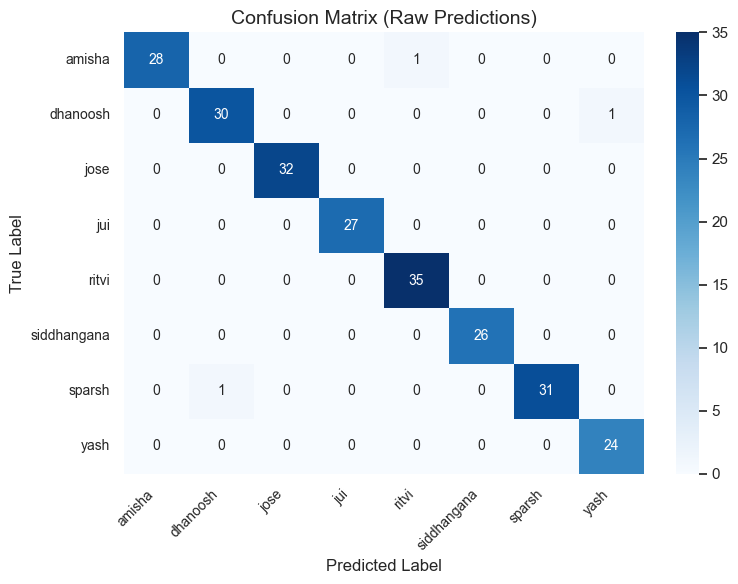


[INFO] Generating Per-Person Accuracy Bar Chart...
[INFO] Saved per_person_accuracy.png


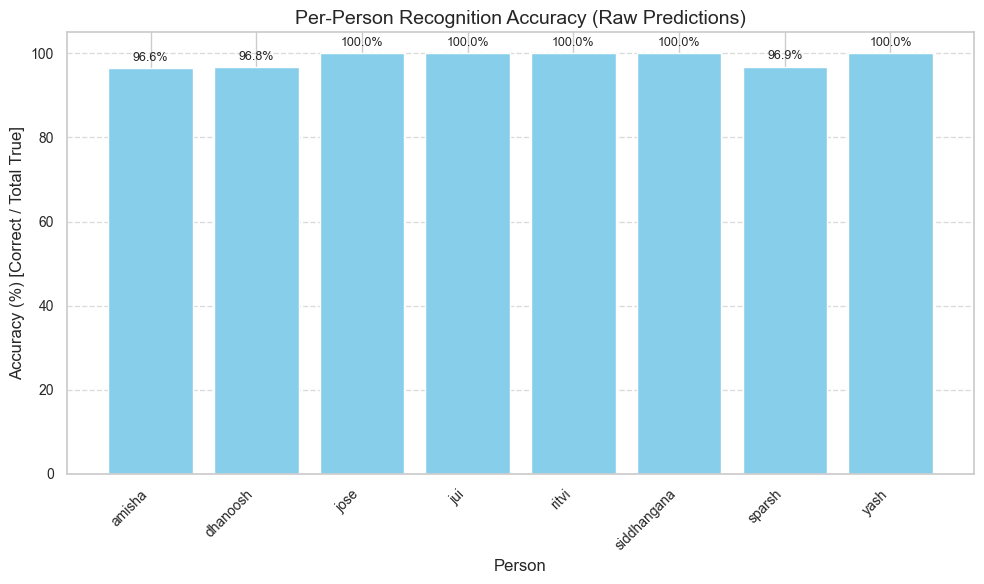


[INFO] Generating Confidence Score Histogram...
[INFO] Saved confidence_histogram.png


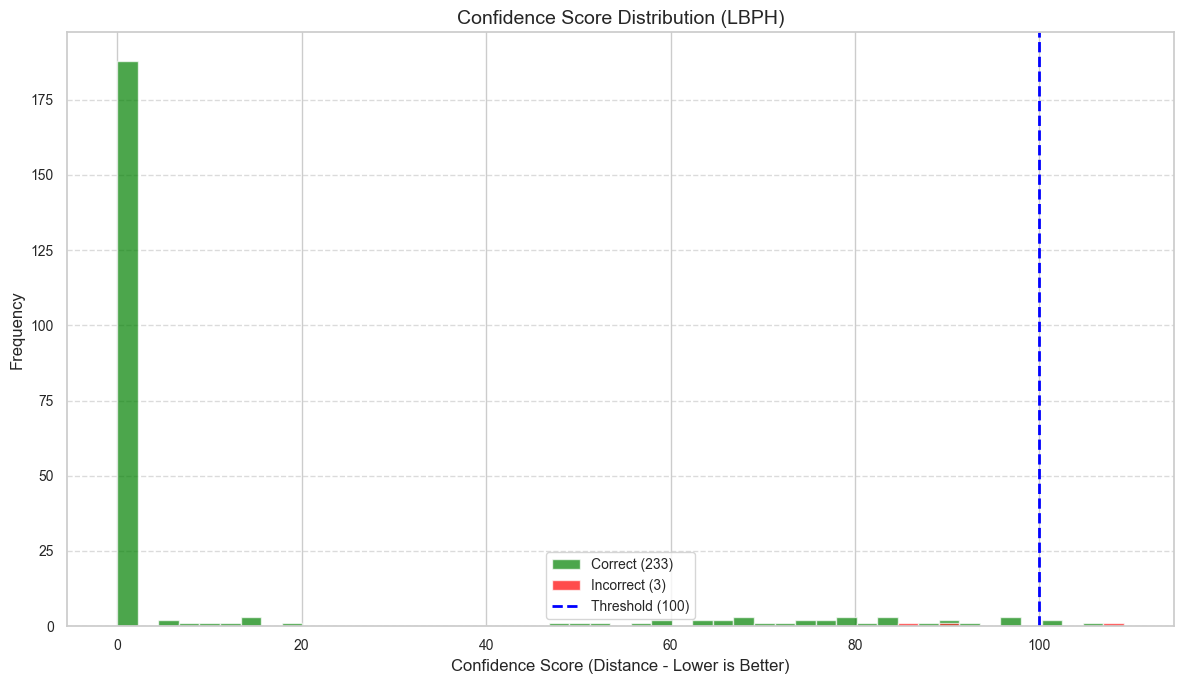


[INFO] Generating Classification Report...

Classification Report (Based on raw predictions)
              precision    recall  f1-score   support

      amisha       1.00      0.97      0.98        29
    dhanoosh       0.97      0.97      0.97        31
        jose       1.00      1.00      1.00        32
         jui       1.00      1.00      1.00        27
       ritvi       0.97      1.00      0.99        35
 siddhangana       1.00      1.00      1.00        26
      sparsh       1.00      0.97      0.98        32
        yash       0.96      1.00      0.98        24

    accuracy                           0.99       236
   macro avg       0.99      0.99      0.99       236
weighted avg       0.99      0.99      0.99       236


Classification Report (Based on predictions *below* threshold)
(Note: Metrics calculated ONLY on accepted predictions)
              precision    recall  f1-score   support

      amisha       1.00      1.00      1.00        28
    dhanoosh       0.97   

In [9]:
# evaluate_visualize.py
import os
import cv2
import dlib
import numpy as np
import json
import time # Keep for potential timing, though not strictly needed for plots
from tqdm import tqdm # Use standard tqdm for scripts
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# --- Configuration ---
# !!! ADJUST THESE PATHS IF NECESSARY !!!
# Path to the dataset used for testing
dataset_path = "png_dataset/png_dataset"
# Filenames for the saved model and label map (MUST MATCH training script)
model_filename = "lbph_model_augmented.yml"
label_map_filename = "label_map_augmented.json"

# Size faces were resized to during training (MUST MATCH training script)
face_size = (100, 100)
# LBPH Confidence threshold (lower values mean higher confidence)
confidence_threshold = 100 # Adjust based on your findings

# --- Global Variables ---
# Load Dlib's pre-trained frontal face detector
print("[INFO] Loading face detector...")
try:
    detector = dlib.get_frontal_face_detector()
except Exception as e:
    print(f"[ERROR] Failed to load dlib face detector: {e}")
    print("[INFO] Ensure dlib is installed correctly.")
    exit()

# --- Load Model and Label Map ---
recognizer = None
label_to_name = None
name_to_label = None # Will be created if label_to_name loads

try:
    print(f"[INFO] Loading trained LBPH model from: {model_filename}")
    recognizer = cv2.face.LBPHFaceRecognizer_create()
    recognizer.read(model_filename) # Load the trained state

    print(f"[INFO] Loading label map from: {label_map_filename}")
    with open(label_map_filename, 'r') as f:
        label_to_name_str_keys = json.load(f)
        # Convert JSON string keys back to integer keys
        label_to_name = {int(k): v for k, v in label_to_name_str_keys.items()}
        name_to_label = {v: k for k, v in label_to_name.items()} # Create reverse map
        print(f"[INFO] Loaded label map: {label_to_name}")

except FileNotFoundError:
    print(f"[ERROR] Model file '{model_filename}' or label map '{label_map_filename}' not found.")
    print("[ERROR] Please ensure these files are in the same directory as the script, or update the paths.")
    exit()
except cv2.error as e:
     print(f"[ERROR] OpenCV error loading model '{model_filename}': {e}")
     print("[INFO] Ensure the model file is valid and generated by the correct OpenCV version.")
     exit()
except Exception as e:
    print(f"[ERROR] Error loading model or label map: {e}")
    exit()

# Check if loading was successful before proceeding
if recognizer is None or label_to_name is None or detector is None:
     print("[ERROR] Failed to initialize recognizer, label map, or detector. Exiting.")
     exit()

# --- Function to Test Model on Dataset (Modified to collect results) ---
def test_model_on_dataset(data_folder_path, recognizer, detector, label_to_name, name_to_label, face_size, confidence_threshold):
    """
    Tests the loaded LBPH model on the dataset images, collects detailed results,
    and prints a summary. Returns lists of true labels, predicted labels, and confidences.
    """
    print("\n" + "="*30)
    print("[INFO] Starting model evaluation on the dataset...")
    print("="*30)

    # --- Input Validation ---
    if not os.path.isdir(data_folder_path):
        print(f"[ERROR] Dataset path not found: {data_folder_path}"); return [], [], []

    # --- Data Collection Lists ---
    list_true_labels = []
    list_pred_labels = []
    list_confidences = []

    known_persons = sorted(list(name_to_label.keys())) # Get person names from map

    # --- Counters for Summary ---
    total_images_scanned = 0
    total_faces_detected = 0
    total_faces_processed = 0
    correct_confident_predictions = 0 # Count predictions below threshold AND correct

    # --- Iterate through known persons based on the label map ---
    print(f"[INFO] Evaluating {len(known_persons)} persons found in label map...")
    for person_name in tqdm(known_persons, desc="Evaluating Persons"):
        person_folder_path = os.path.join(data_folder_path, person_name)
        true_label_id = name_to_label[person_name]

        if not os.path.isdir(person_folder_path):
            print(f"[WARNING] Directory not found for person '{person_name}' at: {person_folder_path}. Skipping.")
            continue

        images_in_folder = 0
        detections_in_folder = 0
        processed_in_folder = 0
        correct_confident_in_folder = 0

        for image_name in os.listdir(person_folder_path):
            if not image_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                continue

            image_path = os.path.join(person_folder_path, image_name)
            total_images_scanned += 1
            images_in_folder += 1

            image = cv2.imread(image_path)
            if image is None: continue # Skip unreadable

            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            # Optional: gray = cv2.equalizeHist(gray) # Keep consistent with training

            try:
                detected_faces = detector(gray, 1) # Use upsampling=1 for potentially higher detection rate in testing
            except Exception as det_err:
                 # print(f"[WARN] Detection error on {image_name}: {det_err}") # Optional debug
                 continue # Skip image on detection error

            if not detected_faces: continue # Skip if no face detected

            total_faces_detected += len(detected_faces)
            detections_in_folder += len(detected_faces)

            # Process only the first detected face for consistency
            face_rect = detected_faces[0]
            x, y, w, h = face_rect.left(), face_rect.top(), face_rect.width(), face_rect.height()
            x, y = max(0, x), max(0, y)
            if w <= 0 or h <= 0 or x + w > gray.shape[1] or y + h > gray.shape[0]:
                 # print(f"[WARN] Invalid face bounds in: {image_path}. Skipping.")
                 continue

            face_roi = gray[y:y+h, x:x+w]
            if face_roi.size == 0: continue

            try:
                resized_face = cv2.resize(face_roi, face_size, interpolation=cv2.INTER_AREA)
            except cv2.error as resize_err:
                # print(f"[WARN] Resize error for face in: {image_path}. Skipping.")
                continue

            # --- Perform prediction AND Store results ---
            try:
                predicted_label_id, confidence = recognizer.predict(resized_face)
                total_faces_processed += 1
                processed_in_folder += 1

                list_true_labels.append(true_label_id)
                list_pred_labels.append(predicted_label_id)
                list_confidences.append(confidence)
            except cv2.error as pred_err:
                 print(f"[WARN] Prediction error for face in: {image_path}. Skipping. Error: {pred_err}")
                 continue
            # ------------------------------------------

            # Check for correct prediction below threshold (for summary)
            if confidence < confidence_threshold and predicted_label_id == true_label_id:
                correct_confident_predictions += 1
                correct_confident_in_folder += 1

    # --- Final Summary ---
    print("\n" + "="*30)
    print("[INFO] Dataset Evaluation Summary")
    print("="*30)
    print(f"Total Images Scanned: {total_images_scanned}")
    print(f"Total Faces Detected: {total_faces_detected}")
    print(f"Total Faces Processed (Prediction Attempted): {total_faces_processed}")
    print(f"Correct & Confident Recognitions (Below Threshold {confidence_threshold}): {correct_confident_predictions}")

    if total_faces_processed > 0:
        accuracy = (correct_confident_predictions / total_faces_processed) * 100
        print(f"Recognition Success Rate (Confident & Correct / Total Processed): {accuracy:.2f}%")
    else:
        print("Recognition Success Rate: N/A (No faces were processed)")
    print("="*30 + "\n")

    if not list_true_labels:
        print("[WARNING] No prediction results were collected during evaluation.")

    return list_true_labels, list_pred_labels, list_confidences

# --- Main Execution Block ---
if __name__ == "__main__":

    print("[INFO] Running evaluation...")
    # Call the evaluation function
    true_labels, pred_labels, confidences = test_model_on_dataset(
        dataset_path,
        recognizer,
        detector,
        label_to_name,
        name_to_label, # Pass the reverse map too
        face_size,
        confidence_threshold
    )

    print(f"\n[INFO] Collected {len(true_labels)} evaluation results.")

    # --- Generate Visualizations and Reports ---
    if not true_labels:
        print("\n[INFO] No evaluation results collected. Skipping visualizations.")
    else:
        print("\n[INFO] Generating performance visualizations...")

        # Prepare labels and names for plots
        known_labels_list = sorted(label_to_name.keys())
        known_names_list = [label_to_name.get(lbl, f"Label {lbl}") for lbl in known_labels_list]

        # Filter for labels actually present in the results to avoid errors
        unique_labels_in_results = set(true_labels) | set(pred_labels)
        valid_known_labels = [lbl for lbl in known_labels_list if lbl in unique_labels_in_results]
        valid_known_names = [label_to_name.get(lbl, f"Label {lbl}") for lbl in valid_known_labels]

        if not valid_known_labels:
             print("[ERROR] None of the known labels were found in the evaluation results. Cannot generate plots.")
        else:
            # Set plot style
            sns.set_theme(style="whitegrid")

            # 1. Confusion Matrix
            print("[INFO] Generating Confusion Matrix...")
            try:
                cm = confusion_matrix(true_labels, pred_labels, labels=valid_known_labels)
                plt.figure(figsize=(max(8, len(valid_known_names)*0.8), max(6, len(valid_known_names)*0.6)))
                sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                            xticklabels=valid_known_names, yticklabels=valid_known_names,
                            annot_kws={"size": 10})
                plt.xlabel('Predicted Label', fontsize=12)
                plt.ylabel('True Label', fontsize=12)
                plt.title('Confusion Matrix (Raw Predictions)', fontsize=14)
                plt.xticks(rotation=45, ha='right', fontsize=10)
                plt.yticks(rotation=0, fontsize=10)
                plt.tight_layout()
                plt.savefig('confusion_matrix.png') # Save the plot
                print("[INFO] Saved confusion_matrix.png")
                plt.show() # Display the plot
            except Exception as e:
                print(f"[ERROR] Failed to generate Confusion Matrix: {e}")


            # 2. Per-Person Accuracy Bar Chart
            if 'cm' in locals() and cm is not None: # Check if CM was created
                print("\n[INFO] Generating Per-Person Accuracy Bar Chart...")
                try:
                    class_counts = cm.sum(axis=1)
                    per_class_accuracy = np.zeros(len(valid_known_labels))

                    for i, count in enumerate(class_counts):
                        if count > 0:
                            per_class_accuracy[i] = cm.diagonal()[i] / count
                        else:
                            per_class_accuracy[i] = np.nan # Use NaN for classes with no true samples

                    plt.figure(figsize=(max(10, len(valid_known_names)*0.6), 6))
                    bars = plt.bar(valid_known_names, per_class_accuracy * 100, color='skyblue')
                    plt.xlabel('Person', fontsize=12)
                    plt.ylabel('Accuracy (%) [Correct / Total True]', fontsize=12)
                    plt.title('Per-Person Recognition Accuracy (Raw Predictions)', fontsize=14)
                    plt.xticks(rotation=45, ha='right', fontsize=10)
                    plt.yticks(fontsize=10)
                    plt.ylim(0, 105)
                    plt.grid(axis='y', linestyle='--', alpha=0.7)

                    # Add text labels to bars
                    for bar in bars:
                        yval = bar.get_height()
                        if not np.isnan(yval):
                            plt.text(bar.get_x() + bar.get_width()/2.0, yval + 1, f'{yval:.1f}%', va='bottom', ha='center', fontsize=9)

                    plt.tight_layout()
                    plt.savefig('per_person_accuracy.png') # Save the plot
                    print("[INFO] Saved per_person_accuracy.png")
                    plt.show() # Display the plot
                except Exception as e:
                     print(f"[ERROR] Failed to generate Per-Person Accuracy chart: {e}")
            else:
                 print("[WARN] Skipping Per-Person Accuracy chart because confusion matrix was not generated.")

            # 3. Confidence Score Histogram
            if confidences:
                print("\n[INFO] Generating Confidence Score Histogram...")
                try:
                    correct_confidences = [conf for true, pred, conf in zip(true_labels, pred_labels, confidences) if true == pred]
                    incorrect_confidences = [conf for true, pred, conf in zip(true_labels, pred_labels, confidences) if true != pred]

                    plt.figure(figsize=(12, 7))
                    max_conf = max(confidences) if confidences else 200
                    min_conf = min(confidences) if confidences else 0
                    bin_count = min(50, max(10, int(max_conf - min_conf))) # Adaptive bins
                    bins = np.linspace(min_conf, max_conf, bin_count)

                    plt.hist(correct_confidences, bins=bins, alpha=0.7, label=f'Correct ({len(correct_confidences)})', color='green')
                    plt.hist(incorrect_confidences, bins=bins, alpha=0.7, label=f'Incorrect ({len(incorrect_confidences)})', color='red')

                    plt.axvline(confidence_threshold, color='blue', linestyle='dashed', linewidth=2, label=f'Threshold ({confidence_threshold})')

                    plt.xlabel('Confidence Score (Distance - Lower is Better)', fontsize=12)
                    plt.ylabel('Frequency', fontsize=12)
                    plt.title('Confidence Score Distribution (LBPH)', fontsize=14)
                    plt.legend(fontsize=10)
                    plt.xticks(fontsize=10)
                    plt.yticks(fontsize=10)
                    plt.grid(axis='y', linestyle='--', alpha=0.7)
                    plt.tight_layout()
                    plt.savefig('confidence_histogram.png') # Save the plot
                    print("[INFO] Saved confidence_histogram.png")
                    plt.show() # Display the plot
                except Exception as e:
                    print(f"[ERROR] Failed to generate Confidence Histogram: {e}")

            # 4. Classification Report (Text)
            print("\n[INFO] Generating Classification Report...")
            try:
                print("\n" + "="*40)
                print("Classification Report (Based on raw predictions)")
                print("="*40)
                report = classification_report(true_labels, pred_labels, labels=valid_known_labels, target_names=valid_known_names, zero_division=0)
                print(report)

                # Optional: Report based on confident predictions
                confident_true = []
                confident_pred = []
                for true, pred, conf in zip(true_labels, pred_labels, confidences):
                    if conf < confidence_threshold:
                        confident_true.append(true)
                        confident_pred.append(pred)

                if confident_true:
                    print("\n" + "="*40)
                    print("Classification Report (Based on predictions *below* threshold)")
                    print("(Note: Metrics calculated ONLY on accepted predictions)")
                    print("="*40)
                    confident_labels_present = sorted(list(set(confident_true) | set(confident_pred)))
                    valid_confident_labels = [lbl for lbl in valid_known_labels if lbl in confident_labels_present]
                    valid_confident_names = [label_to_name.get(lbl, f"Label {lbl}") for lbl in valid_confident_labels]

                    if valid_confident_labels:
                        report_confident = classification_report(confident_true, confident_pred, labels=valid_confident_labels, target_names=valid_confident_names, zero_division=0)
                        print(report_confident)
                    else:
                        print("No known labels found among confident predictions.")
                else:
                    print("\nNo predictions were made below the confidence threshold.")
            except Exception as e:
                print(f"[ERROR] Failed to generate Classification Report: {e}")


    print("\n[INFO] Evaluation and visualization process finished.")